In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/Suganya/Downloads/archive-3/Test.csv")

In [3]:
df.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [4]:
print("Number of reviews: {}".format(len(df)))

Number of reviews: 5000


In [5]:
import re

In [6]:
def replace_singlechar(review, default_replace=" "):
  review = re.sub(r'\s+[a-zA-Z]\s+', default_replace, review)
  return review

In [7]:
def remove_space(review, default_replace=" "):
  review = re.sub(r'\s+', default_replace, review,flags=re.I)
  return review

In [8]:
def to_lowercase(review):
  review = review.lower()
  return review

In [9]:
import emoji

In [10]:
def demojize(review):
  review = emoji.demojize(review)
  return review

In [11]:
def word_repetition(review):
  review = re.sub(r'(.)\1+', r'\1\1', review)
  return review

In [12]:
def punct_repetition(review, default_replace=""):
  review = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, review)
  return review

In [13]:
import contractions

In [14]:
def fix_contractions(review):
  review = contractions.fix(review)
  return review

In [15]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Suganya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
def tokenize(review):
  tokens = word_tokenize(review)
  return tokens

In [17]:
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Suganya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
def custom_tokenize(review,
                    keep_punct = False,
                    keep_alnum = False,
                    keep_stop = False):
  
  token_list = word_tokenize(review)

  if not keep_punct:
    token_list = [token for token in token_list
                  if token not in string.punctuation]

  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  if not keep_stop:
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list

In [19]:
from nltk.stem.snowball import SnowballStemmer

In [20]:
def stem_tokens(tokens, stemmer):
  token_list = []
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list

In [90]:
def process_review(review, verbose=False):
  if verbose: print("Initial tweet: {}".format(review))

  ## Twitter Features
  review = replace_singlechar(review) # replace single char
  review = remove_space(review) # remove multiple space with single space
  if verbose: print("Post Twitter processing tweet: {}".format(review))

  ## Word Features
  review = to_lowercase(review) # lower case
  review = fix_contractions(review) # replace contractions
  review = punct_repetition(review) # replace punctuation repetition
  review = word_repetition(review) # replace word repetition
  review = demojize(review) # replace emojis
  if verbose: print("Post Word processing tweet: {}".format(review))

  ## Tokenization & Stemming
  tokens = custom_tokenize(review, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # define stemmer
  stem = stem_tokens(tokens, stemmer) # stem tokens

  return stem

In [91]:
df["tokens"] = df["text"].apply(process_review)

In [92]:
df.head()

,text,label,tokens
0,I always wrote this series off as being a comp...,0,"[alway, wrote, seri, complet, jim, belushi, in..."
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0,"[watch, purcel, typic, mari, kate, ashley, far..."
2,This movie was so poorly written and directed ...,0,"[movi, poor, written, direct, fell, asleep, mi..."
3,The most interesting thing about Miryang (Secr...,1,"[interest, thing, miryang, secret, sunshin, ac..."
4,"when i first read about ""berlin am meer"" i did...",0,"[first, read, berlin, meer, not, expect, much,..."


In [93]:
X = df["tokens"].tolist()
y = df["label"].tolist()

In [94]:
accuracy=[]

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    train_size=0.80)

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [99]:
def fit_tfidf(tweet_corpus):
  tf_vect = TfidfVectorizer(preprocessor=lambda x: x,
                            tokenizer=lambda x: x)
  tf_vect.fit(tweet_corpus)
  return tf_vect

In [100]:
def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

In [101]:
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

/opt/anaconda3/envs/sugi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [102]:
model_lr_tf = fit_lr(X_train_tf, y_train)

In [103]:
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

In [104]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [105]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))
LR_acc=accuracy_score(y_test, y_pred_lr_tf.round())

LR Model Accuracy: 84.80%


In [106]:
accuracy.append(LR_acc*100)

In [107]:
def fit_RF(X_train, y_train):
  model = RandomForestClassifier()
  model.fit(X_train, y_train)
  return model

In [108]:
model_RF_tf = fit_RF(X_train_tf, y_train)

In [109]:
y_pred_RF_tf = model_RF_tf.predict(X_test_tf)

In [110]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_RF_tf)))

LR Model Accuracy: 81.40%


In [111]:
RF_acc=accuracy_score(y_test, y_pred_RF_tf.round())
accuracy.append(RF_acc*100)

In [112]:
def fit_DT(X_train, y_train):
  model = DecisionTreeClassifier()
  model.fit(X_train, y_train)
  return model

In [113]:
model_DT_tf = fit_DT(X_train_tf, y_train)

In [114]:
y_pred_DT_tf = model_DT_tf.predict(X_test_tf)

In [115]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_DT_tf)))

LR Model Accuracy: 67.50%


In [116]:
DT_acc=accuracy_score(y_test, y_pred_DT_tf.round())
accuracy.append(DT_acc*100)

In [117]:
your_review = """the movie have good vibe. deliverse wonderful message"""

In [118]:
def predict_review(review):
  processed_review = process_review(review)
  transformed_review = tf.transform([processed_review])
  prediction = model_lr_tf.predict(transformed_review)

  if prediction == 1:
    return "Prediction is positive sentiment"
  else:
    return "Prediction is negative sentiment"

In [119]:
predict_review(your_review)

'Prediction is positive sentiment'

In [120]:
accuracy

[84.8, 81.39999999999999, 67.5]

In [121]:
Algorithm=['LR','RF','DT']

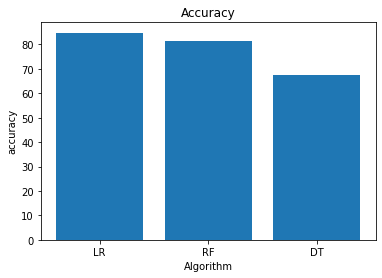

In [123]:
plt.bar(Algorithm, accuracy)
plt.title('Accuracy')
plt.xlabel('Algorithm')
plt.ylabel('accuracy')
plt.show()